In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from pytorch_metric_learning.losses import ArcFaceLoss
import pickle
import numpy as np
from typing import Dict, Union, List, Tuple 
import random
from matplotlib import pyplot as plt

In [3]:
dataset_path="dataset"
batch_size = 32
num_epochs = 10
train_split=0.8
val_split=0.1

In [4]:

class FlowerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Путь к корневой папке датасета.
            transform (callable, optional): Трансформации для изображений.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.images = []
        self.labels = []

        # Собираем список всех изображений и их меток
        for cls_name in self.classes:
            cls_path = os.path.join(root_dir, cls_name)
            if os.path.isdir(cls_path):
                for img_name in os.listdir(cls_path):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(cls_path, img_name))
                        self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Загружаем изображение
        image = Image.open(img_path).convert('RGB')

        # Применяем трансформации, если они есть
        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
torch.manual_seed(42)


In [6]:
full_dataset = FlowerDataset(root_dir=dataset_path, transform=None)


In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
# Разделение на train, val, test
total_size = len(full_dataset)
train_size = int(train_split * total_size)
val_size = int(val_split * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)

train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

class_names = full_dataset.classes

In [9]:
def train_model(model, arcface_loss, train_loader, val_loader, num_epochs, device, save_path="best_model.pth"):
    """
    Обучает модель с ArcFace loss и сохраняет лучшие веса по F1-score.
    """
    optimizer = optim.Adam(list(model.parameters()) + list(arcface_loss.parameters()), lr=0.001)
    best_f1 = 0.0

    for epoch in range(num_epochs):
        model.train()
        arcface_loss.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            features = model(images)  # Получаем признаки
            loss = arcface_loss(features, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        arcface_loss.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                features = model(images)
                logits = arcface_loss.get_logits(features)
                _, preds = torch.max(logits, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        f1 = f1_score(all_labels, all_preds, average='macro')

        print(f"Эпоха {epoch+1}/{num_epochs}, "
              f"F1-score: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), save_path)
            print(f"Сохранены лучшие веса с F1-score: {best_f1:.4f}")

    return best_f1

def test_model(model, arcface_loss, test_loader, device):
    """
    Тестирует модель на тестовом наборе.
    """
    model.eval()
    arcface_loss.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            features = model(images)
            logits = arcface_loss.get_logits(features)
            _, preds = torch.max(logits, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Тестовый F1-score: {f1:.4f}")
    return f1


In [10]:
save_path = "weights/best_flower_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Инициализируем модель
model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
num_classes = len(class_names)

# Инициализируем ArcFace loss
arcface_loss = ArcFaceLoss(
    num_classes=num_classes,
    embedding_size=model.classifier[-1].in_features,
    scale=30.0,
    margin=0.5
).to(device)

model.classifier[-1] = nn.Identity()   #nn.Linear(model.classifier[-1].in_features, num_classes)

model = model.to(device)

# Обучение
print("Начало обучения...")
best_f1 = train_model(model, arcface_loss, train_loader, val_loader, num_epochs, device, save_path)

# Тестирование (используем валидационный loader как тестовый для примера)
print("Тестирование модели...")
model.load_state_dict(torch.load(save_path))
test_f1 = test_model(model, arcface_loss, test_loader, device)

print(f"Лучший F1-score на валидации: {best_f1:.4f}")
print(f"F1-score на тесте: {test_f1:.4f}")

Начало обучения...
Эпоха 1/10, F1-score: 0.8951
Сохранены лучшие веса с F1-score: 0.8951
Эпоха 2/10, F1-score: 0.8940
Эпоха 3/10, F1-score: 0.8808
Эпоха 4/10, F1-score: 0.8958
Сохранены лучшие веса с F1-score: 0.8958
Эпоха 5/10, F1-score: 0.9310
Сохранены лучшие веса с F1-score: 0.9310
Эпоха 6/10, F1-score: 0.8771
Эпоха 7/10, F1-score: 0.8756
Эпоха 8/10, F1-score: 0.8833
Эпоха 9/10, F1-score: 0.9043
Эпоха 10/10, F1-score: 0.8964
Тестирование модели...
Тестовый F1-score: 0.9096
Лучший F1-score на валидации: 0.9310
F1-score на тесте: 0.9096


In [11]:
class EmbeddingGetter:
    def __init__(self, path_to_weights : str, device : torch.device, transform):
        self.embedding_model = models.efficientnet_v2_s()
        self.embedding_model.classifier[-1] = nn.Identity()  
        
        self.embedding_model.load_state_dict(torch.load(path_to_weights))
        self.embedding_model.to(device)
        self.embedding_model.eval()

        self.device = device
        self.transform = transform
    
    def get_embedding(self, image_path):
        image = Image.open(image_path).convert('RGB')
        tensor = self.transform(image)
        with torch.no_grad():
            emb = self.embedding_model(tensor.unsqueeze(0).to(self.device)).detach().cpu().numpy()
        return emb[0]

In [12]:
embeddings_getter = EmbeddingGetter("weights/best_flower_model.pth",
                                    device,
                                    val_test_transforms)

In [25]:
embeddings_dict = {}
test_indices = test_dataset.indices
images_test = [test_dataset.dataset.images[idx] for idx in test_indices]
for image_path in images_test:
    with torch.no_grad():
        embeddings_dict[image_path] = embeddings_getter.get_embedding(image_path)

In [26]:
with open('embeddings_dict.pickle', 'wb') as handle:
    pickle.dump(embeddings_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
def cosine_distance(emb1: np.ndarray, emb2: np.ndarray) -> float:
    """
    Вычисляет косинусное расстояние между двумя эмбеддингами.
    
    Args:
        emb1: Первый эмбеддинг (numpy массив или PyTorch тензор).
        emb2: Второй эмбеддинг (numpy массив или PyTorch тензор).
    
    Returns:
        float: Косинусное расстояние (1 - косинусное сходство).
    """
    # Нормализация
    emb1 = emb1 / np.linalg.norm(emb1)
    emb2 = emb2 / np.linalg.norm(emb2)
    
    # Косинусное сходство
    cosine_similarity = np.dot(emb1, emb2)
    
    # Косинусное расстояние
    return 1.0 - cosine_similarity

In [28]:
def find_top_k_similar(
    query: np.ndarray,
    embedding_dict: Dict[str, np.ndarray],
    k: int = 5
) -> List[Tuple[str, float]]:
    """
    Находит топ-k ближайших изображений по косинусному расстоянию.
    
    Args:
        query (Union[str, np.ndarray]): Путь к изображению или эмбеддинг запроса.
        embedding_dict (Dict[str, np.ndarray]): Словарь {путь_к_файлу: эмбеддинг}.
        model (nn.Module, optional): Модель для извлечения эмбеддинга (если query - путь).
        device (torch.device, optional): Устройство для модели (если query - путь).
        k (int): Количество возвращаемых результатов.
    
    Returns:
        List[Tuple[str, float]]: Список из k пар (путь_к_файлу, косинусное_расстояние).
    """

    query_embedding = np.array(query, dtype=np.float32)

    # Вычисляем расстояния
    distances = []
    for img_path, emb in embedding_dict.items():
        distance = cosine_distance(query_embedding, emb)
        distances.append((img_path, distance))
    
    # Сортируем по расстоянию и берем топ-k
    distances.sort(key=lambda x: x[1])
    return distances[:k]

In [29]:
def plot_results(query_path: str, top_k_results: List[Tuple[str, float]]):
    """
    Отображает запросное изображение и топ-k ближайших изображений.
    
    Args:
        query_path: Путь к изображению запроса.
        top_k_results: Список пар (путь_к_файлу, косинусное_расстояние).
    """
    fig, axes = plt.subplots(1, len(top_k_results) + 1, figsize=(15, 5))
    
    # Отображаем запросное изображение
    query_img = Image.open(query_path).convert('RGB')
    axes[0].imshow(query_img)
    axes[0].set_title('Запрос')
    axes[0].axis('off')
    
    # Отображаем топ-k ближайших изображений
    for i, (img_path, distance) in enumerate(top_k_results):
        img = Image.open(img_path).convert('RGB')
        axes[i + 1].imshow(img)
        axes[i + 1].set_title(f'Топ-{i+1}\nSim: {1-distance:.2f}')
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [30]:
embedding_dict_path = "embeddings_dict.pickle"  # Путь к сохраненному словарю
num_queries = 5
k = 5

# Загружаем словарь эмбеддингов
with open(embedding_dict_path, 'rb') as f:
    embeddings_dict = pickle.load(f)


1. Путь: dataset/sunflower/200557977_bf24d9550b.jpg, Косинусное расстояние: 0.0861
2. Путь: dataset/sunflower/5999024446_5721493894.jpg, Косинусное расстояние: 0.0865
3. Путь: dataset/sunflower/6204049536_1ac4f09232_n.jpg, Косинусное расстояние: 0.0888
4. Путь: dataset/sunflower/4872892690_52dc25b0b4.jpg, Косинусное расстояние: 0.0916
5. Путь: dataset/sunflower/14646280372_dd50be16e4_n.jpg, Косинусное расстояние: 0.0973


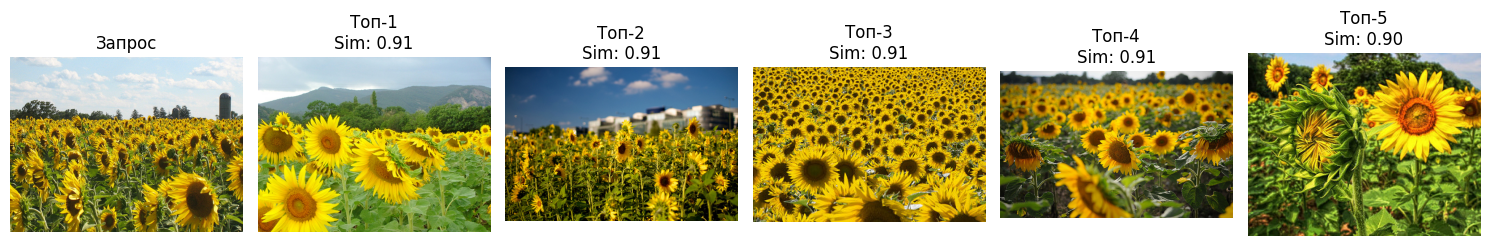

1. Путь: dataset/sunflower/40410814_fba3837226_n.jpg, Косинусное расстояние: 0.0417
2. Путь: dataset/sunflower/5231868667_f0baa71feb_n.jpg, Косинусное расстояние: 0.0512
3. Путь: dataset/sunflower/14646279002_9cdf97be97_n.jpg, Косинусное расстояние: 0.0658
4. Путь: dataset/sunflower/10386525005_fd0b7d6c55_n.jpg, Косинусное расстояние: 0.0815
5. Путь: dataset/sunflower/147804446_ef9244c8ce_m.jpg, Косинусное расстояние: 0.0816


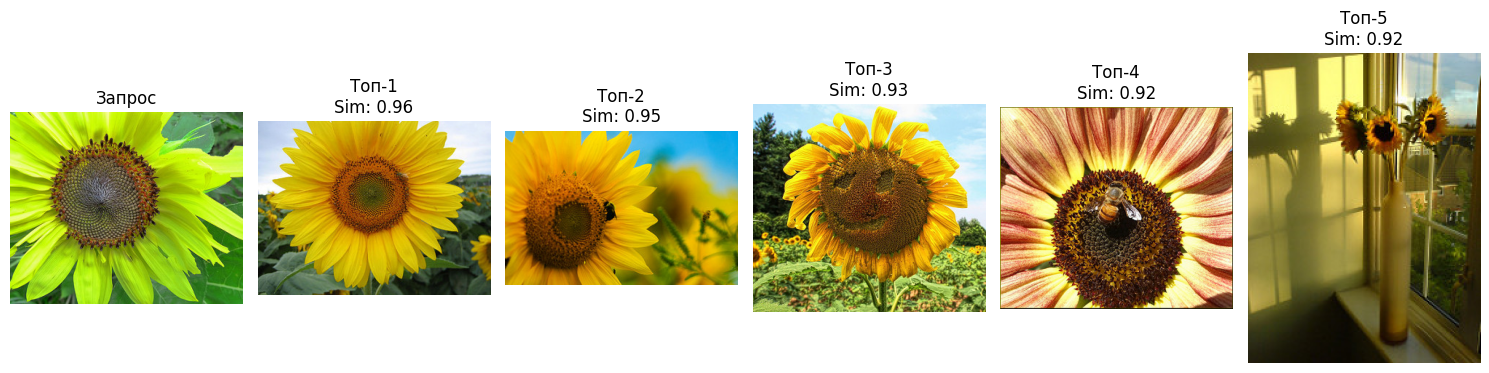

1. Путь: dataset/rose/3407482427_49d5c75291_m.jpg, Косинусное расстояние: 0.1120
2. Путь: dataset/rose/921138131_9e1393eb2b_m.jpg, Косинусное расстояние: 0.1282
3. Путь: dataset/rose/12434194695_a7c4e73c6b_n.jpg, Косинусное расстояние: 0.2165
4. Путь: dataset/rose/5181899042_0a6ffe0c8a_n.jpg, Косинусное расстояние: 0.2616
5. Путь: dataset/rose/5002447434_9b06760f63_n.jpg, Косинусное расстояние: 0.2711


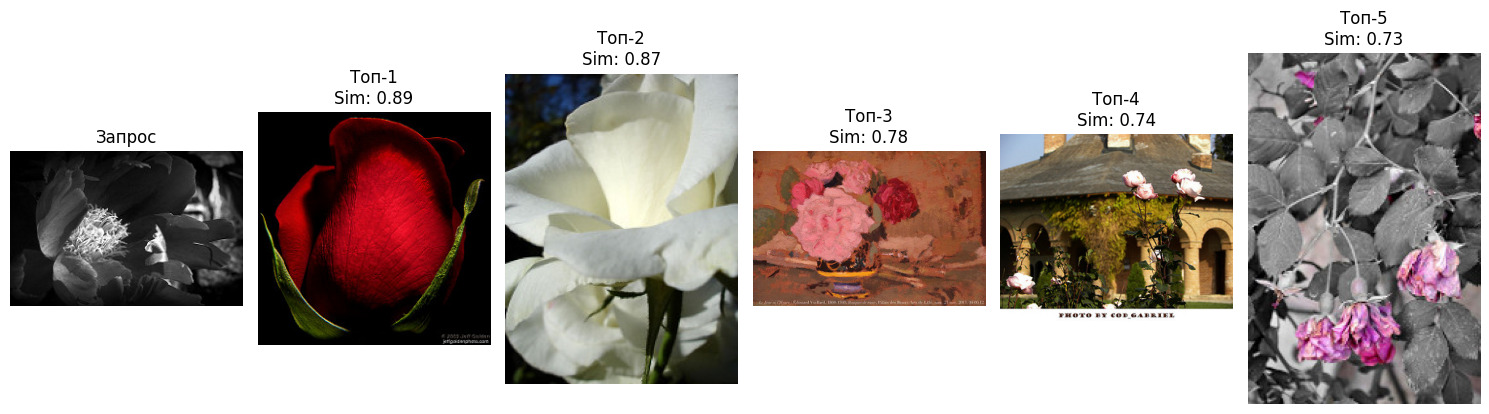

1. Путь: dataset/sunflower/9111896677_ff0b6fa6f6_n.jpg, Косинусное расстояние: 0.0723
2. Путь: dataset/sunflower/184682320_73ccf74710.jpg, Косинусное расстояние: 0.0858
3. Путь: dataset/sunflower/9558630626_52a1b7d702_m.jpg, Косинусное расстояние: 0.0940
4. Путь: dataset/sunflower/7581713708_8eae6794f2.jpg, Косинусное расстояние: 0.1069
5. Путь: dataset/sunflower/6908789145_814d448bb1_n.jpg, Косинусное расстояние: 0.1075


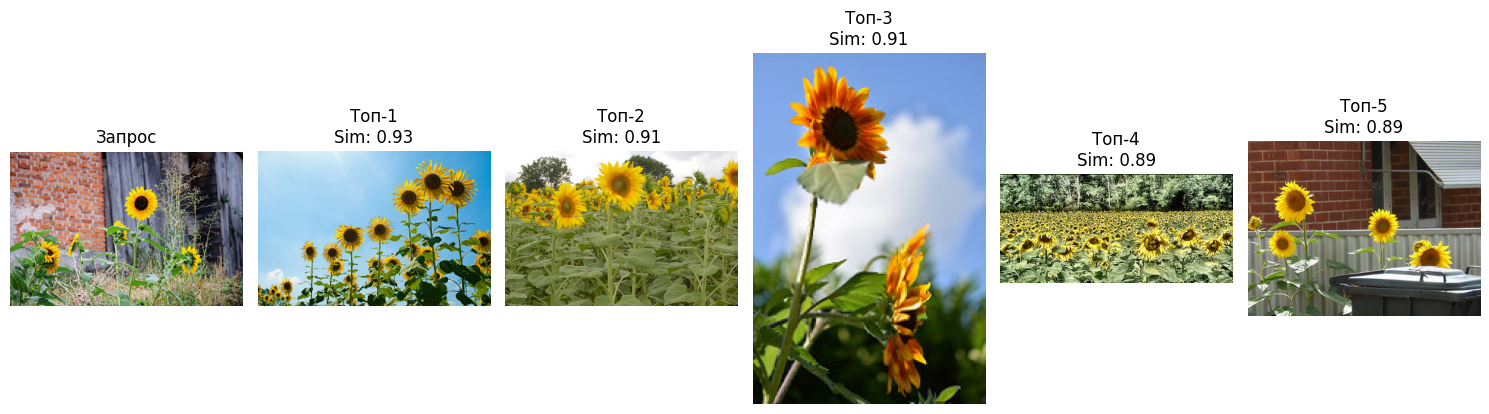

1. Путь: dataset/tulip/142218310_d06005030a_n.jpg, Косинусное расстояние: 0.0362
2. Путь: dataset/tulip/434146736_310a42d9cb_m.jpg, Косинусное расстояние: 0.0376
3. Путь: dataset/tulip/4042180234_64cd2859c9_m.jpg, Косинусное расстояние: 0.0401
4. Путь: dataset/tulip/5730908127_da871df0f8.jpg, Косинусное расстояние: 0.0426
5. Путь: dataset/tulip/8520482921_21dd204ebd_n.jpg, Косинусное расстояние: 0.0443


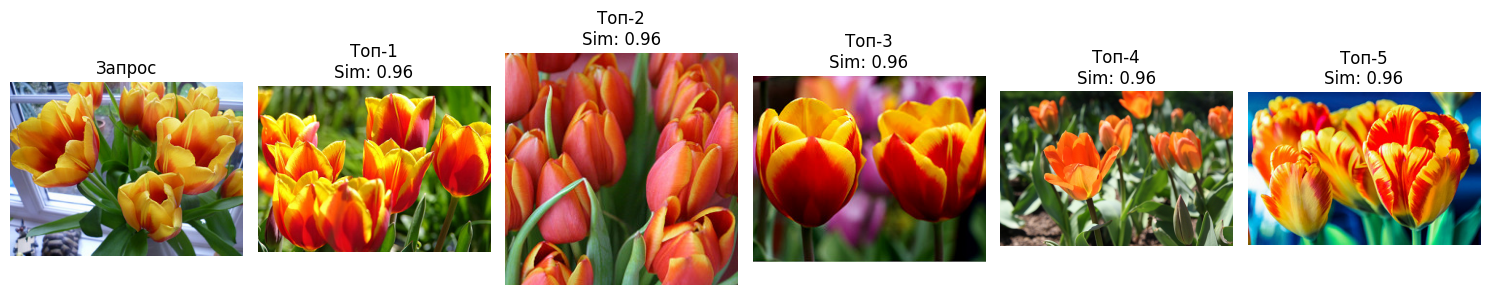

In [34]:
val_indices = val_dataset.indices
images_val = [val_dataset.dataset.images[idx] for idx in val_indices]
random.seed(42)
query_paths = random.sample(images_val, num_queries)
query_embeddings = [embeddings_getter.get_embedding(img_path) for img_path in query_paths]

# Для каждого запроса находим топ-5 ближайших изображений и визуализируем
for query_path, query_embedding  in zip(query_paths, query_embeddings):
    top_k_results = find_top_k_similar(query_embedding, embeddings_dict, k)
    # print(f"\nЗапрос: {query_path}")
    # print(f"Топ-{k} ближайших изображений:")
    for i, (img_path, distance) in enumerate(top_k_results, 1):
        print(f"{i}. Путь: {img_path}, Косинусное расстояние: {distance:.4f}")
    plot_results(query_path, top_k_results)